In [1]:
import sys
import os
import numpy as np
import pandas as pd
import gym
import Configuration.config as cfg
from gym_atena.envs.atena_env_cont import ATENAEnvCont
from Evaluation.notebook_utils import *
from Evaluation.evaluator_tf import evaluate_model
from live_recommender_agent import TFRecommenderAgent, find_latest_trained_model
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Configuration loaded with:
  - humanity_coeff: 1.0
  - diversity_coeff: 2.0
  - kl_coeff: 1.5
  - compaction_coeff: 2.0
  - adam_lr: 0.0003
  - ppo_gamma: 0.995
  - ppo_lambda: 0.97
Registering ATENAcont-v0 environment
✅ Using Snorkel compatibility adapter
Configuration loaded with:
  - humanity_coeff: 1.0
  - diversity_coeff: 2.0
  - kl_coeff: 1.5
  - compaction_coeff: 2.0
  - adam_lr: 0.0003
  - ppo_gamma: 0.995
  - ppo_lambda: 0.97
✅ REWARD STABILIZER: DISABLED (stable mode like train_ipdate-1009-18:54.png)


/Users/edenmironi/Desktop/school/third year/Atena/ATENA-A-EDA/Compare/.venv/lib/python3.12/site-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


# Clean Evaluation for ATENA-TF

This notebook provides comprehensive evaluation of the ATENA-TF agent:
- Performance metrics across datasets
- Action distribution analysis
- Reward component breakdown
- Session length analysis
- Comparison with baselines


## Configuration

Set up paths and parameters for evaluation.


In [2]:
# Find latest trained model
try:
    model_path = find_latest_trained_model()
    print(f" Using model: {model_path}")
    model_available = True
except FileNotFoundError:
    print("  No trained model found. Please train a model first:")
    print("   python main.py")
    model_available = False

# Evaluation parameters
num_episodes_per_dataset = 5  # Run multiple episodes per dataset for statistics
datasets_to_evaluate = list(range(4))  # Datasets 0-3 (flights)
use_most_probable = True  # Deterministic actions

print(f"\nEvaluation Settings:")
print(f"  Episodes per dataset: {num_episodes_per_dataset}")
print(f"  Datasets: {datasets_to_evaluate}")
print(f"  Deterministic: {use_most_probable}")


✅ Found latest model: results/0511-resumed/best_agent (best_agent)
✅ Using model: results/0511-resumed/best_agent

Evaluation Settings:
  Episodes per dataset: 5
  Datasets: [0, 1, 2, 3]
  Deterministic: True


## Run Comprehensive Evaluation

Evaluate the agent on all datasets with multiple episodes.


In [3]:
if model_available:
    all_results = []
    
    for dataset_num in datasets_to_evaluate:
        print(f"\n{'='*70}")
        print(f"Evaluating Dataset {dataset_num}")
        print(f"{'='*70}")
        
        for episode_num in range(num_episodes_per_dataset):
            print(f"\n  Episode {episode_num + 1}/{num_episodes_per_dataset}...")
            
            # Create fresh agent
            agent = TFRecommenderAgent(
                model_path=model_path,
                dataset_number=dataset_num
            )
            
            # Run episode
            info_hist, total_reward = run_episode(
                agent=agent,
                dataset_number=dataset_num,
                env=agent.env,
                most_probable=use_most_probable,
                verbose=False
            )
            
            # Extract action types
            action_types = {'filter': 0, 'group': 0, 'back': 0, 'other': 0}
            for info, reward in info_hist:
                action = info['action'].lower()
                if 'back' in action:
                    action_types['back'] += 1
                elif 'filter' in action:
                    action_types['filter'] += 1
                elif 'group' in action:
                    action_types['group'] += 1
                else:
                    action_types['other'] += 1
            
            # Store results
            result = {
                'dataset': dataset_num,
                'episode': episode_num,
                'total_reward': total_reward,
                'num_steps': len(info_hist),
                'avg_reward': total_reward / len(info_hist),
                'filter_actions': action_types['filter'],
                'group_actions': action_types['group'],
                'back_actions': action_types['back'],
                'other_actions': action_types['other']
            }
            
            all_results.append(result)
            
            print(f"    Reward: {total_reward:.2f}, Steps: {len(info_hist)}")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    print(f"\n\n Evaluation complete! Collected {len(all_results)} episodes.")
else:
    print("Skipping evaluation (no model available)")



Evaluating Dataset 0

  Episode 1/5...
🔄 Loading datasets for schema: NETWORKING
























































































































































































































































































































































































































































































































































































































































































































































































































































































































































/Users/edenmironi/Desktop/school/third year/Atena/ATENA-A-EDA/Compare/.venv/lib/python3.12/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/Users/edenmironi/Desktop/school/third year/Atena/ATENA-A-EDA/Compare/atena-tf 2/gym_atena/envs/atena_snorkel/snorkel_compatibility.py:122: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  return super().find_class(module, name)
INFO:root:Computing O...
INFO:root:Estimating \mu...


✅ Datasets loaded successfully!
🔧 Fixing old snorkel.learning references in checkpoint...
✅ Successfully loaded Snorkel checkpoint with compatibility fixes
🔧 Initializing real LabelModel with checkpoint data...
   Fitting LabelModel with dummy data: L_train(100, 51), class_balance=[0.5, 0.5]


INFO:root:[0 epochs]: TRAIN:[loss=126.232]
INFO:root:[10 epochs]: TRAIN:[loss=43.360]
INFO:root:[20 epochs]: TRAIN:[loss=21.711]
INFO:root:[30 epochs]: TRAIN:[loss=9.648]
INFO:root:[40 epochs]: TRAIN:[loss=4.772]
INFO:root:[50 epochs]: TRAIN:[loss=4.575]
INFO:root:[60 epochs]: TRAIN:[loss=4.668]
INFO:root:[70 epochs]: TRAIN:[loss=4.482]
INFO:root:[80 epochs]: TRAIN:[loss=4.404]
INFO:root:[90 epochs]: TRAIN:[loss=4.396]
INFO:root:Finished Training


✅ Real LabelModel initialized and ready for predictions!
✅ Loaded Snorkel model from snorkel_checkpoints
Enhanced ATENA Environment initialized with:
  - Rule-based humanity scoring: ✓
  - Enhanced diversity rewards: ✓
  - Detailed reward tracking: ✓
  - Max steps: 12
🎯 Initializing ParamSoftmaxPolicy (master's SUCCESS architecture - 600 channels!)
✅ Using environment parametric segments: ((), (12, 3, 26), (12,))
✅ FFParamSoftmax network built with 2 layers x 600 units
🎯 FFParamSoftmax Policy initialized:
  - Hidden channels: 600 (master's 600)
  - Parametric segments: ((), (12, 3, 26), (12,))
  - Pre-output size: 56
  - Beta (temperature): 1.0
🏗️  Building networks...
✅ Networks built - Policy vars: 6, Value vars: 6
✅ Policy weights loaded from results/0511-resumed/best_agent (.weights.h5 format)
✅ Value weights loaded from results/0511-resumed/best_agent (.weights.h5 format)
⚠️ Failed to load model: 'NoneType' object has no attribute 'mean'
⚠️ No compatible trained model found at res

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(2), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(9), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(19.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(2), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(11), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(10), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [0, 0, 0, 0.5, 0, 0]]
/Users/edenmironi/De

🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 0.012436773061644061
   total_interestingness: 0.012436773061644061
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔄 BACK ACTION: humanity rewards only
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_s

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(2), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(9), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(19.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(2), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(11), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(10), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [0, 0, 0, 0.5, 0, 0]]
/Users/edenmironi/De

🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 0.013007090457000301
   total_interestingness: 0.013007090457000301
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 0.012436773061644061
   total_

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(2), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(9), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(19.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(2), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(11), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(10), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [0, 0, 0, 0.5, 0, 0]]
/Users/edenmironi/De

🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 0.012436773061644061
   total_interestingness: 0.012436773061644061
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔄 BACK ACTION: humanity rewards only
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_s

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(2), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(9), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(19.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(2), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(11), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(10), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [0, 0, 0, 0.5, 0, 0]]


🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.9554855150022394
   total_interestingness: 1.9554855150022394
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.9369268683946659
   total_intere

/Users/edenmironi/Desktop/school/third year/Atena/ATENA-A-EDA/Compare/.venv/lib/python3.12/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/Users/edenmironi/Desktop/school/third year/Atena/ATENA-A-EDA/Compare/atena-tf 2/gym_atena/envs/atena_snorkel/snorkel_compatibility.py:122: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  return super().find_class(module, name)
INFO:root:Computing O...
INFO:root:Estimating \mu...
INFO:root:[0 epochs]: TRAIN:[loss=127.248]
INFO:root:[10 epochs]: TRAIN:[loss=44.178]
INFO:root:[20 epochs]: TRAIN:[loss=22.175]
INFO:root:[30 epochs]: TRAIN:[loss=9.763]
INFO:root:[40 epochs]: TRAIN:[loss=4.885]
INFO:root:[50 epochs]: TRAIN:[loss=4.772]
INFO:root:[60 epochs]: TRAIN:[loss=4.822]
INFO:root:[70 epochs]: TRAIN:[los

🔧 Fixing old snorkel.learning references in checkpoint...
✅ Successfully loaded Snorkel checkpoint with compatibility fixes
🔧 Initializing real LabelModel with checkpoint data...
   Fitting LabelModel with dummy data: L_train(100, 51), class_balance=[0.5, 0.5]
✅ Real LabelModel initialized and ready for predictions!
✅ Loaded Snorkel model from snorkel_checkpoints
Enhanced ATENA Environment initialized with:
  - Rule-based humanity scoring: ✓
  - Enhanced diversity rewards: ✓
  - Detailed reward tracking: ✓
  - Max steps: 12
🎯 Initializing ParamSoftmaxPolicy (master's SUCCESS architecture - 600 channels!)
✅ Using environment parametric segments: ((), (12, 3, 26), (12,))
✅ FFParamSoftmax network built with 2 layers x 600 units
🎯 FFParamSoftmax Policy initialized:
  - Hidden channels: 600 (master's 600)
  - Parametric segments: ((), (12, 3, 26), (12,))
  - Pre-output size: 56
  - Beta (temperature): 1.0
🏗️  Building networks...
✅ Networks built - Policy vars: 6, Value vars: 6
✅ Policy wei

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(2), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(9), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(19.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(2), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(11), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(10), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [0, 0, 0, 0.5, 0, 0]]
/Users/edenmironi/De

🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.9554855150022394
   total_interestingness: 1.9554855150022394
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.9369268683946659
   total_intere

INFO:root:[10 epochs]: TRAIN:[loss=43.972]
INFO:root:[20 epochs]: TRAIN:[loss=22.051]
INFO:root:[30 epochs]: TRAIN:[loss=9.719]
INFO:root:[40 epochs]: TRAIN:[loss=4.847]
INFO:root:[50 epochs]: TRAIN:[loss=4.703]
INFO:root:[60 epochs]: TRAIN:[loss=4.758]
INFO:root:[70 epochs]: TRAIN:[loss=4.552]
INFO:root:[80 epochs]: TRAIN:[loss=4.475]
INFO:root:[90 epochs]: TRAIN:[loss=4.467]
INFO:root:Finished Training


✅ Real LabelModel initialized and ready for predictions!
✅ Loaded Snorkel model from snorkel_checkpoints
Enhanced ATENA Environment initialized with:
  - Rule-based humanity scoring: ✓
  - Enhanced diversity rewards: ✓
  - Detailed reward tracking: ✓
  - Max steps: 12
🎯 Initializing ParamSoftmaxPolicy (master's SUCCESS architecture - 600 channels!)
✅ Using environment parametric segments: ((), (12, 3, 26), (12,))
✅ FFParamSoftmax network built with 2 layers x 600 units
🎯 FFParamSoftmax Policy initialized:
  - Hidden channels: 600 (master's 600)
  - Parametric segments: ((), (12, 3, 26), (12,))
  - Pre-output size: 56
  - Beta (temperature): 1.0
🏗️  Building networks...
✅ Networks built - Policy vars: 6, Value vars: 6
✅ Policy weights loaded from results/0511-resumed/best_agent (.weights.h5 format)
✅ Value weights loaded from results/0511-resumed/best_agent (.weights.h5 format)
⚠️ Failed to load model: 'NoneType' object has no attribute 'mean'
⚠️ No compatible trained model found at res

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(7.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(3), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(1), np.float32(19.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(1), np.float32(19.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(10), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(9), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(2), np.

✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.2516188325548359
   total_interestingness: 1.2516188325548359
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.1112213889352158
   total_interestingness: 1.1112213889352158
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel pr

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(7.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(3), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(1), np.float32(19.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(1), np.float32(19.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(10), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(9), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(2), np.

🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.4027973825472535
   total_interestingness: 1.4027973825472535
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_hum

INFO:root:[20 epochs]: TRAIN:[loss=22.344]
INFO:root:[30 epochs]: TRAIN:[loss=9.535]
INFO:root:[40 epochs]: TRAIN:[loss=4.767]
INFO:root:[50 epochs]: TRAIN:[loss=4.773]
INFO:root:[60 epochs]: TRAIN:[loss=4.782]
INFO:root:[70 epochs]: TRAIN:[loss=4.549]
INFO:root:[80 epochs]: TRAIN:[loss=4.482]
INFO:root:[90 epochs]: TRAIN:[loss=4.481]
INFO:root:Finished Training


✅ Real LabelModel initialized and ready for predictions!
✅ Loaded Snorkel model from snorkel_checkpoints
Enhanced ATENA Environment initialized with:
  - Rule-based humanity scoring: ✓
  - Enhanced diversity rewards: ✓
  - Detailed reward tracking: ✓
  - Max steps: 12
🎯 Initializing ParamSoftmaxPolicy (master's SUCCESS architecture - 600 channels!)
✅ Using environment parametric segments: ((), (12, 3, 26), (12,))
✅ FFParamSoftmax network built with 2 layers x 600 units
🎯 FFParamSoftmax Policy initialized:
  - Hidden channels: 600 (master's 600)
  - Parametric segments: ((), (12, 3, 26), (12,))
  - Pre-output size: 56
  - Beta (temperature): 1.0
🏗️  Building networks...
✅ Networks built - Policy vars: 6, Value vars: 6
✅ Policy weights loaded from results/0511-resumed/best_agent (.weights.h5 format)
✅ Value weights loaded from results/0511-resumed/best_agent (.weights.h5 format)
⚠️ Failed to load model: 'NoneType' object has no attribute 'mean'
⚠️ No compatible trained model found at res

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(7.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(3), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(1), np.float32(19.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(1), np.float32(19.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(10), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(9), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(2), np.

🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.1112213889352158
   total_interestingness: 1.1112213889352158
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_hum

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(7.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(3), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(1), np.float32(19.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(1), np.float32(19.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(10), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(9), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(2), np.

🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.

INFO:root:[80 epochs]: TRAIN:[loss=4.686]
INFO:root:[90 epochs]: TRAIN:[loss=4.675]
INFO:root:Finished Training


✅ Real LabelModel initialized and ready for predictions!
✅ Loaded Snorkel model from snorkel_checkpoints
Enhanced ATENA Environment initialized with:
  - Rule-based humanity scoring: ✓
  - Enhanced diversity rewards: ✓
  - Detailed reward tracking: ✓
  - Max steps: 12
🎯 Initializing ParamSoftmaxPolicy (master's SUCCESS architecture - 600 channels!)
✅ Using environment parametric segments: ((), (12, 3, 26), (12,))
✅ FFParamSoftmax network built with 2 layers x 600 units
🎯 FFParamSoftmax Policy initialized:
  - Hidden channels: 600 (master's 600)
  - Parametric segments: ((), (12, 3, 26), (12,))
  - Pre-output size: 56
  - Beta (temperature): 1.0
🏗️  Building networks...
✅ Networks built - Policy vars: 6, Value vars: 6
✅ Policy weights loaded from results/0511-resumed/best_agent (.weights.h5 format)
✅ Value weights loaded from results/0511-resumed/best_agent (.weights.h5 format)
⚠️ Failed to load model: 'NoneType' object has no attribute 'mean'
⚠️ No compatible trained model found at res

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(7.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(3), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(1), np.float32(19.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(1), np.float32(19.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(10), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(9), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(9), np.int64(2), np.

🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.2516188325548359
   total_interestingness: 1.2516188325548359
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_hum

INFO:root:[60 epochs]: TRAIN:[loss=4.995]
INFO:root:[70 epochs]: TRAIN:[loss=4.789]
INFO:root:[80 epochs]: TRAIN:[loss=4.720]
INFO:root:[90 epochs]: TRAIN:[loss=4.719]
INFO:root:Finished Training


✅ Real LabelModel initialized and ready for predictions!
✅ Loaded Snorkel model from snorkel_checkpoints
Enhanced ATENA Environment initialized with:
  - Rule-based humanity scoring: ✓
  - Enhanced diversity rewards: ✓
  - Detailed reward tracking: ✓
  - Max steps: 12
🎯 Initializing ParamSoftmaxPolicy (master's SUCCESS architecture - 600 channels!)
✅ Using environment parametric segments: ((), (12, 3, 26), (12,))
✅ FFParamSoftmax network built with 2 layers x 600 units
🎯 FFParamSoftmax Policy initialized:
  - Hidden channels: 600 (master's 600)
  - Parametric segments: ((), (12, 3, 26), (12,))
  - Pre-output size: 56
  - Beta (temperature): 1.0
🏗️  Building networks...
✅ Networks built - Policy vars: 6, Value vars: 6
✅ Policy weights loaded from results/0511-resumed/best_agent (.weights.h5 format)
✅ Value weights loaded from results/0511-resumed/best_agent (.weights.h5 format)
⚠️ Failed to load model: 'NoneType' object has no attribute 'mean'
⚠️ No compatible trained model found at res

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(2), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(3), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(2), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), n

✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000


INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(2), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(3), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(2), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), n

🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.000, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.421845300966717
   total_interestingness: 1.421845300966717
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.000, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=-0.999808
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=-0.999808
🎯 Snorkel humanity: -0.999808
🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_hu

INFO:root:[30 epochs]: TRAIN:[loss=9.725]
INFO:root:[40 epochs]: TRAIN:[loss=4.906]
INFO:root:[50 epochs]: TRAIN:[loss=4.843]
INFO:root:[60 epochs]: TRAIN:[loss=4.891]
INFO:root:[70 epochs]: TRAIN:[loss=4.679]
INFO:root:[80 epochs]: TRAIN:[loss=4.608]
INFO:root:[90 epochs]: TRAIN:[loss=4.604]
INFO:root:Finished Training


✅ Real LabelModel initialized and ready for predictions!
✅ Loaded Snorkel model from snorkel_checkpoints
Enhanced ATENA Environment initialized with:
  - Rule-based humanity scoring: ✓
  - Enhanced diversity rewards: ✓
  - Detailed reward tracking: ✓
  - Max steps: 12
🎯 Initializing ParamSoftmaxPolicy (master's SUCCESS architecture - 600 channels!)
✅ Using environment parametric segments: ((), (12, 3, 26), (12,))
✅ FFParamSoftmax network built with 2 layers x 600 units
🎯 FFParamSoftmax Policy initialized:
  - Hidden channels: 600 (master's 600)
  - Parametric segments: ((), (12, 3, 26), (12,))
  - Pre-output size: 56
  - Beta (temperature): 1.0
🏗️  Building networks...
✅ Networks built - Policy vars: 6, Value vars: 6
✅ Policy weights loaded from results/0511-resumed/best_agent (.weights.h5 format)
✅ Value weights loaded from results/0511-resumed/best_agent (.weights.h5 format)
⚠️ Failed to load model: 'NoneType' object has no attribute 'mean'
⚠️ No compatible trained model found at res

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(2), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(3), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(2), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), n

🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
    Reward: -8.48, Steps: 12

  Episode 4/5...
🔧 Fixing old snorkel.learning references in checkpoint...
✅ Successfully loaded Snorkel checkpoint with compatibility fixes
🔧 Initializing real LabelModel 

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(2), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(3), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(2), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), n

🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Rea

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(2), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(3), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(2), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(1), n

🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
    Reward: -8.33, Steps: 12

Evaluating Dataset 3

  Episode 1/5...
🔧 Fixing old snorkel.learning references in checkpoint...
✅ Successfully loaded Snorkel checkpoint with compatibility fixes
🔧 Initial

🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.9129753584677613
   total_interestingness: 1.9129753584677613
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.2949683888126047
   total_intere

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(2), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(2), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(3), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [0, 0, 0, 0.5, 0, 0], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)]]
/Users/edenmironi/Deskt

🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
    Reward: 20.75, Steps: 12

  Episode 2/5...
🔧 Fixing old snorkel.learning references in checkpoint...
✅ Successfully loaded Snorkel checkpoint with compatibility fixes
🔧 Initializing real LabelModel with checkpoint data...
   Fitting LabelModel with dummy data: L_train(100, 51), class_balance=[0.5, 0.5]
✅ Real LabelModel initialized and ready for predictions!
✅ Loaded Snorkel model from snorkel_checkpoints
Enhanced ATENA Environment initialized with:
  - Rule-based humanity scoring: ✓
  - Enhanced diversity rewards: ✓
  - Detailed reward tracking: ✓
  - Max steps: 12
🎯 Initializing ParamSoft

🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.000, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.9796605269870498
   total_interestingness: 1.9796605269870498
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.000, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=-0.999884
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=-0.999884
🎯 Snorkel humanity: -0.999884
🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.9687793502146453
   total_int

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(2), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(2), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(3), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [0, 0, 0, 0.5, 0, 0], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)]]
/Users/edenmironi/Deskt

🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.130657864735337
   total_interestingness: 1.130657864735337
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_human

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(2), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(2), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(3), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [0, 0, 0, 0.5, 0, 0], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)]]
/Users/edenmironi/Deskt

🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.2949683888126047
   total_interestingness: 1.2949683888126047
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.000, std=0.000
🔄 BACK ACTION: humanity rewards only
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.000, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=-0.999914
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snor

INFO:root:[60 epochs]: TRAIN:[loss=4.822]
INFO:root:[70 epochs]: TRAIN:[loss=4.584]
INFO:root:[80 epochs]: TRAIN:[loss=4.543]
INFO:root:[90 epochs]: TRAIN:[loss=4.550]
INFO:root:Finished Training


✅ Real LabelModel initialized and ready for predictions!
✅ Loaded Snorkel model from snorkel_checkpoints
Enhanced ATENA Environment initialized with:
  - Rule-based humanity scoring: ✓
  - Enhanced diversity rewards: ✓
  - Detailed reward tracking: ✓
  - Max steps: 12
🎯 Initializing ParamSoftmaxPolicy (master's SUCCESS architecture - 600 channels!)
✅ Using environment parametric segments: ((), (12, 3, 26), (12,))
✅ FFParamSoftmax network built with 2 layers x 600 units
🎯 FFParamSoftmax Policy initialized:
  - Hidden channels: 600 (master's 600)
  - Parametric segments: ((), (12, 3, 26), (12,))
  - Pre-output size: 56
  - Beta (temperature): 1.0
🏗️  Building networks...
✅ Networks built - Policy vars: 6, Value vars: 6
✅ Policy weights loaded from results/0511-resumed/best_agent (.weights.h5 format)
✅ Value weights loaded from results/0511-resumed/best_agent (.weights.h5 format)
⚠️ Failed to load model: 'NoneType' object has no attribute 'mean'
⚠️ No compatible trained model found at res

🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.000, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.9470273375312557
   total_interestingness: 1.9470273375312557
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.000, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=-0.999914
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=-0.999914
🎯 Snorkel humanity: -0.999914
🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.9129753584677613
   total_int

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(2), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(2), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(3), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [0, 0, 0, 0.5, 0, 0], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)]]
/Users/edenmironi/Deskt

🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
    Reward: 20.74, Steps: 12

  Episode 5/5...
🔧 Fixing old snorkel.learning references in checkpoint...
✅ Successfully loaded Snorkel checkpoint with compatibility fixes
🔧 Initializing real LabelModel with checkpoint data...
   Fitting LabelModel with dummy data: L_train(100, 51), class_balance=[0.5, 0.5]
✅ Real LabelModel initialized and ready for predictions!
✅ Loaded Snorkel model from snorkel_checkpoints
Enhanced ATENA Environment initialized with:
  - Rule-based humanity scoring: ✓
  - Enhanced diversity rewards: ✓
  - Detailed reward tracking: ✓
  - Max steps: 12
🎯 Initializing ParamSoft

🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.037, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.9796605269870498
   total_interestingness: 1.9796605269870498
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.037, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=-0.925770
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=-0.925770
🎯 Snorkel humanity: -0.925770
🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.9687793502146453
   total_int

INFO:atena_env_cont:actions:[[np.int64(1), np.int64(6), np.int64(1), np.float32(11.5), np.int64(0), np.int64(0)], [np.int64(1), np.int64(3), np.int64(2), np.float32(23.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(1), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(2), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(3), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [0, 0, 0, 0.5, 0, 0], [np.int64(2), np.int64(7), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(6), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)], [np.int64(2), np.int64(5), np.int64(0), np.float32(0.5), np.int64(0), np.int64(0)]]


🔧 Rule-based humanity coefficient applied: 1.0
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 Diversity coefficient applied (main calc): 2.0
🔧 Compaction coefficient applied: 2.0
🎯 MASTER-EXACT REWARD:
   action_type: 2
   kl_distance: 0
   compaction_gain: 1.130657864735337
   total_interestingness: 1.130657864735337
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_humanity=0.000000
🎯 Snorkel humanity: 0.000000
🔧 Humanity coefficient applied (same display penalty): 1.0
🚨 MASTER-EXACT: Skipping interestingness & humanity due to same display penalty
🎯 Using REAL LabelModel.predict_proba() on (1, 51) matrix
✅ Real Snorkel predictions: mean=0.500, std=0.000
🔧 BEFORE coeff: r_snorkel_humanity=0.000000
🔧 Using current humanity_coeff: 1.0
🔧 AFTER coeff: r_snorkel_human

## Summary Statistics

Aggregate statistics across all episodes.


In [4]:
if model_available:
    # Overall summary
    print("="*70)
    print("OVERALL STATISTICS")
    print("="*70)
    print(f"\nTotal Episodes: {len(results_df)}")
    print(f"Average Reward: {results_df['total_reward'].mean():.2f} ± {results_df['total_reward'].std():.2f}")
    print(f"Average Steps: {results_df['num_steps'].mean():.2f} ± {results_df['num_steps'].std():.2f}")
    print(f"Average Reward per Step: {results_df['avg_reward'].mean():.4f} ± {results_df['avg_reward'].std():.4f}")
    
    # Per-dataset summary
    print(f"\n\nPER-DATASET STATISTICS")
    print("="*70)
    dataset_summary = results_df.groupby('dataset').agg({
        'total_reward': ['mean', 'std'],
        'num_steps': ['mean', 'std'],
        'avg_reward': ['mean', 'std'],
        'filter_actions': 'mean',
        'group_actions': 'mean',
        'back_actions': 'mean'
    }).round(2)
    
    display(dataset_summary)
else:
    print("Statistics require a trained model")


OVERALL STATISTICS

Total Episodes: 20
Average Reward: 5.62 ± 11.49
Average Steps: 12.00 ± 0.00
Average Reward per Step: 0.4685 ± 0.9575


PER-DATASET STATISTICS


total_reward       num_steps      avg_reward       filter_actions  \
                mean   std      mean  std       mean   std           mean   
dataset                                                                     
0              11.01  1.54      12.0  0.0       0.92  0.13            3.0   
1              -0.89  0.00      12.0  0.0      -0.07  0.00            5.0   
2              -8.44  0.06      12.0  0.0      -0.70  0.01            7.0   
3              20.81  0.14      12.0  0.0       1.73  0.01            2.0   

        group_actions back_actions  
                 mean         mean  
dataset                             
0                 8.0          1.0  
1                 7.0          0.0  
2                 5.0          0.0  
3                 9.0          1.0

## Visualization: Rewards by Dataset


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

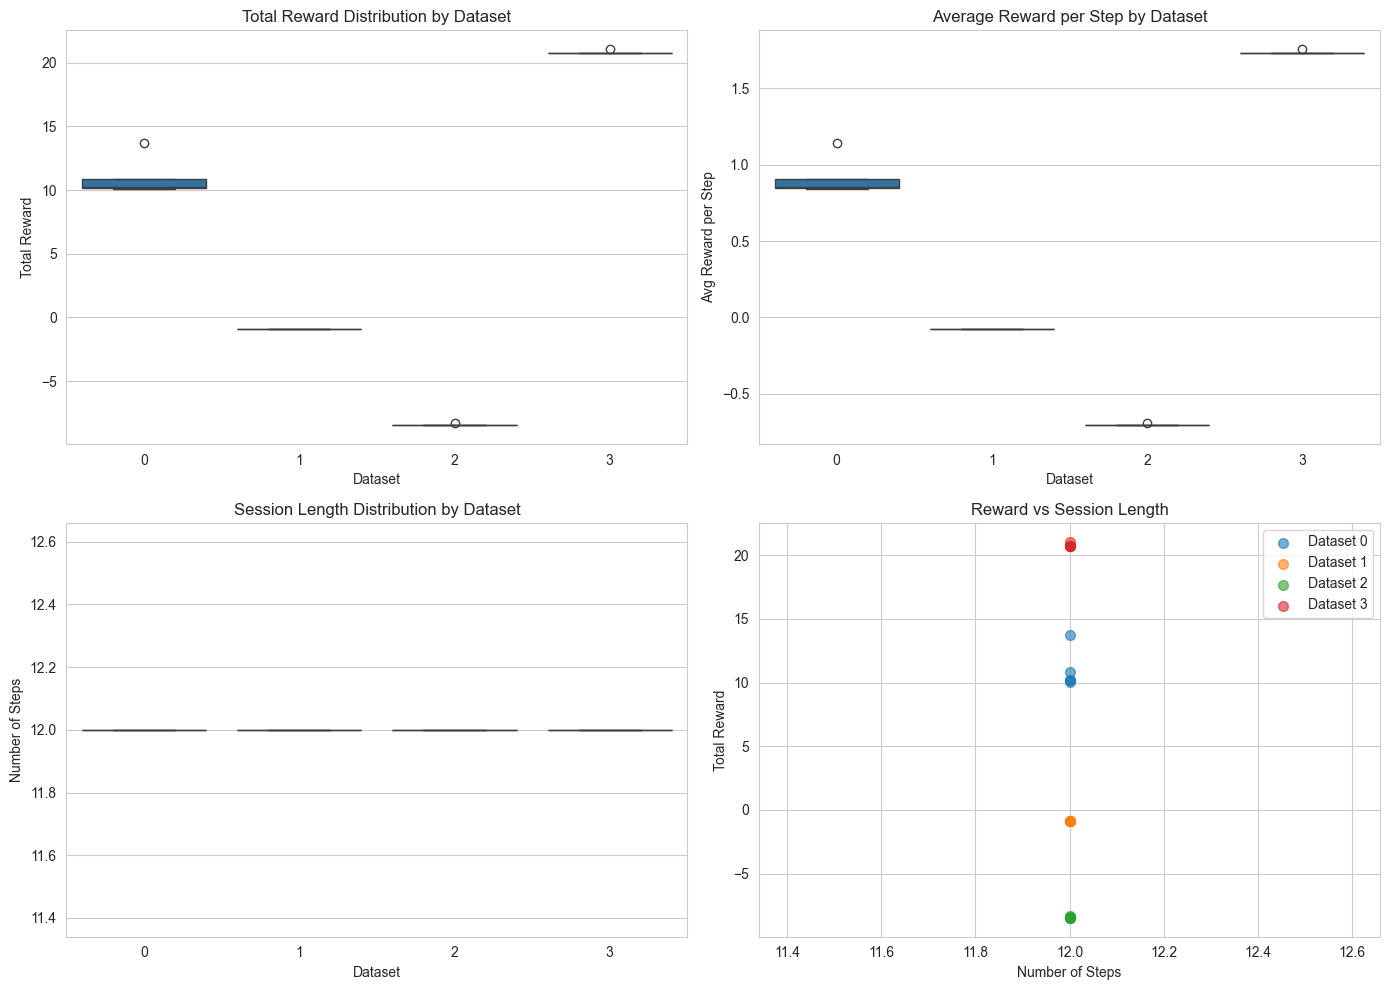

In [5]:
if model_available:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Total reward boxplot
    sns.boxplot(data=results_df, x='dataset', y='total_reward', ax=axes[0, 0])
    axes[0, 0].set_title('Total Reward Distribution by Dataset')
    axes[0, 0].set_xlabel('Dataset')
    axes[0, 0].set_ylabel('Total Reward')
    
    # Average reward per step boxplot
    sns.boxplot(data=results_df, x='dataset', y='avg_reward', ax=axes[0, 1])
    axes[0, 1].set_title('Average Reward per Step by Dataset')
    axes[0, 1].set_xlabel('Dataset')
    axes[0, 1].set_ylabel('Avg Reward per Step')
    
    # Session length boxplot
    sns.boxplot(data=results_df, x='dataset', y='num_steps', ax=axes[1, 0])
    axes[1, 0].set_title('Session Length Distribution by Dataset')
    axes[1, 0].set_xlabel('Dataset')
    axes[1, 0].set_ylabel('Number of Steps')
    
    # Reward vs Steps scatter
    for dataset in datasets_to_evaluate:
        data = results_df[results_df['dataset'] == dataset]
        axes[1, 1].scatter(data['num_steps'], data['total_reward'], 
                          label=f'Dataset {dataset}', alpha=0.6, s=50)
    axes[1, 1].set_xlabel('Number of Steps')
    axes[1, 1].set_ylabel('Total Reward')
    axes[1, 1].set_title('Reward vs Session Length')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Visualization requires a trained model")


## Visualization: Action Distribution


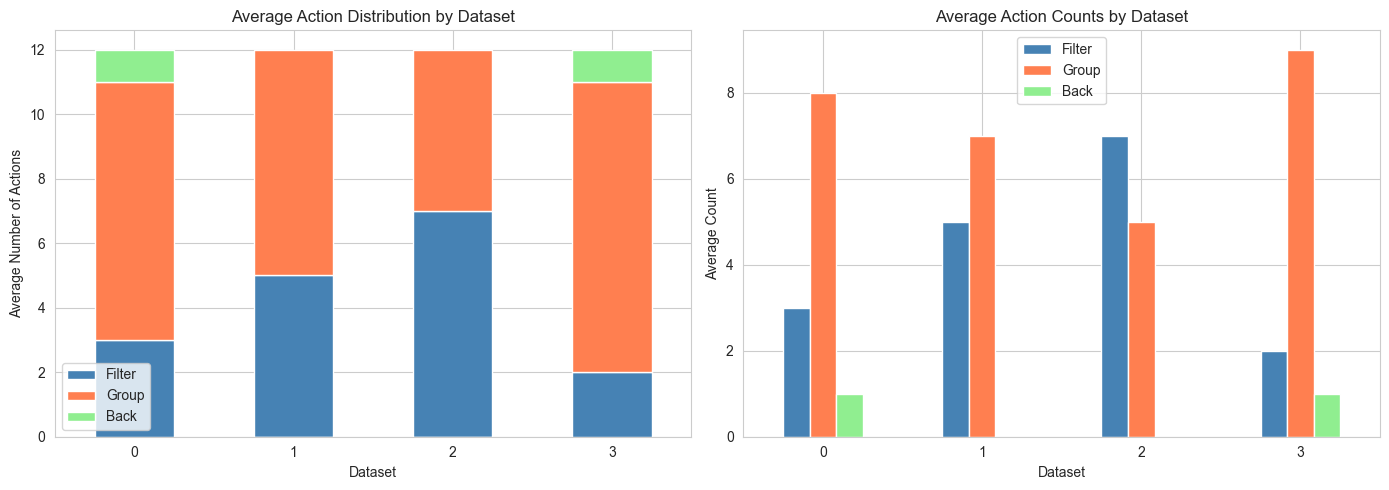

In [6]:
if model_available:
    # Calculate mean action counts per dataset
    action_summary = results_df.groupby('dataset')[['filter_actions', 'group_actions', 'back_actions']].mean()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Stacked bar chart
    action_summary.plot(kind='bar', stacked=True, ax=axes[0], 
                        color=['steelblue', 'coral', 'lightgreen'])
    axes[0].set_title('Average Action Distribution by Dataset')
    axes[0].set_xlabel('Dataset')
    axes[0].set_ylabel('Average Number of Actions')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
    axes[0].legend(['Filter', 'Group', 'Back'])
    
    # Grouped bar chart
    action_summary.plot(kind='bar', ax=axes[1],
                        color=['steelblue', 'coral', 'lightgreen'])
    axes[1].set_title('Average Action Counts by Dataset')
    axes[1].set_xlabel('Dataset')
    axes[1].set_ylabel('Average Count')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
    axes[1].legend(['Filter', 'Group', 'Back'])
    
    plt.tight_layout()
    plt.show()
else:
    print("Visualization requires a trained model")


## Export Results

Save results to CSV for further analysis.


In [7]:
if model_available:
    # Save detailed results
    output_file = 'evaluation_results.csv'
    results_df.to_csv(output_file, index=False)
    print(f" Results saved to: {output_file}")
    
    # Save summary statistics
    summary_file = 'evaluation_summary.csv'
    dataset_summary.to_csv(summary_file)
    print(f" Summary saved to: {summary_file}")
    
    print(f"\n\nFinal Results Preview:")
    display(results_df.head(10))
else:
    print("Export requires a trained model")


✅ Results saved to: evaluation_results.csv
✅ Summary saved to: evaluation_summary.csv


Final Results Preview:


,dataset,episode,total_reward,num_steps,avg_reward,filter_actions,group_actions,back_actions,other_actions
0,0,0,10.071175,12,0.839265,3,8,1,0
1,0,1,10.222118,12,0.851843,3,8,1,0
2,0,2,10.190142,12,0.849178,3,8,1,0
3,0,3,10.830360,12,0.902530,3,8,1,0
4,0,4,13.718652,12,1.143221,3,8,1,0
5,1,0,-0.885644,12,-0.073804,5,7,0,0
6,1,1,-0.885644,12,-0.073804,5,7,0,0
7,1,2,-0.885644,12,-0.073804,5,7,0,0
8,1,3,-0.885644,12,-0.073804,5,7,0,0
9,1,4,-0.885644,12,-0.073804,5,7,0,0
